[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/francisco-ortin/data-science-course/blob/main/deep-learning/activation/image_classifier.ipynb)
[![License: CC BY-NC-SA 4.0](https://img.shields.io/badge/License-CC%20BY--NC--SA%204.0-lightgrey.svg)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

# Multiclass image classifier using an MLP

We will build a multiclass image classifier using an MLP NN.

We use [Fashion-MNIST](https://keras.io/api/datasets/fashion_mnist/), a Keras dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Each class represents an article of clothing:

- 0 T-shirt/top.
- 1 Trouser.
- 2 Pullover.
- 3 Dress.
- 4 Coat.
- 5 Sandal.
- 6 Shirt.
- 7 Sneaker.
- 8 Bag.
- 9 Ankle boot.

<img src="img/fashion-mnist.png" width="600px"/>

In [42]:
# make sure the required packages are installed
%pip install pandas numpy seaborn matplotlib scikit-learn keras tensorflow --quiet
repo='data-science-course'
module='deep-learning/activation'
# if running in colab, install the required packages and copy the necessary files
if get_ipython().__class__.__module__.startswith('google.colab'):
    import os
    if not os.path.exists(repo):
        !git clone --filter=blob:none --sparse https://github.com/francisco-ortin/data-science-course.git 2>/dev/null
        !cd {repo} && git sparse-checkout init --cone && git sparse-checkout set {module}  2>/dev/null
    !cp --update {repo}/{module}/*.py . 2>/dev/null
    !mkdir -p img data
    !mv {repo}/{module}/img/* img/. 2>/dev/null
    !mv {repo}/{module}/data/* data/. 2>/dev/null

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import pandas as pd
import os

Note: you may need to restart the kernel to use updated packages.


## Data preparation

We download fashion MNIST the dataset from keras. It is already shuffled and split into a training set (60,000 images) and a test set (10,000 images). We take 10,000 images from the training set to create a validation set.


In [43]:
CLASS_LABELS = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
# We take the last 10,000 images from the training set for validation and the rest of them for training
N_VAL_INSTANCES = 10_000
# We take the last 10,000 images from the training set for validation and the rest of them for training
X_train, y_train = X_train_full[:-N_VAL_INSTANCES], y_train_full[:-N_VAL_INSTANCES]
X_val, y_val = X_train_full[-N_VAL_INSTANCES:], y_train_full[-N_VAL_INSTANCES:]
# Show shapes of all the datasets
print(f"Shape of X_train = {X_train.shape} and y_train = {y_train.shape}.")
print(f"Shape of X_val = {X_val.shape} and y_val = {y_val.shape}.")
print(f"Shape of X_test = {X_test.shape} and y_test = {y_test.shape}.")

Shape of X_train = (50000, 28, 28) and y_train = (50000,).
Shape of X_val = (10000, 28, 28) and y_val = (10000,).
Shape of X_test = (10000, 28, 28) and y_test = (10000,).


We show the first image and its class label.

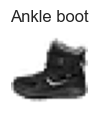

In [44]:
plt.figure(figsize=(1, 1))  # 1 inch x 1 inch figure
plt.imshow(X_train[0], cmap="binary")
plt.title(CLASS_LABELS[y_train[0]])
plt.axis('off')
plt.show()

X holds gray colors from 0 to 255 (1 byte) for each pixel. y holds the type of clothing: an int from 0 to 9.

In [45]:
print(f"Values of X_train (gray colors): {np.unique(X_train)}")
print(f"Values of Y_train (types of clothes): {np.unique(y_train)}")

Values of X_train (gray colors): [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 2

We rescale the colors to real numbers between 0 and 1. This is a very common preprocessing step in neural networks to make the optimization easier.

In [46]:
X_train, X_val, X_test = X_train / 255, X_val / 255, X_test / 255
print(f"Values of X_train (gray colors): {np.unique(X_train).round(decimals=3)}")

Values of X_train (gray colors): [0.    0.004 0.008 0.012 0.016 0.02  0.024 0.027 0.031 0.035 0.039 0.043
 0.047 0.051 0.055 0.059 0.063 0.067 0.071 0.075 0.078 0.082 0.086 0.09
 0.094 0.098 0.102 0.106 0.11  0.114 0.118 0.122 0.125 0.129 0.133 0.137
 0.141 0.145 0.149 0.153 0.157 0.161 0.165 0.169 0.173 0.176 0.18  0.184
 0.188 0.192 0.196 0.2   0.204 0.208 0.212 0.216 0.22  0.224 0.227 0.231
 0.235 0.239 0.243 0.247 0.251 0.255 0.259 0.263 0.267 0.271 0.275 0.278
 0.282 0.286 0.29  0.294 0.298 0.302 0.306 0.31  0.314 0.318 0.322 0.325
 0.329 0.333 0.337 0.341 0.345 0.349 0.353 0.357 0.361 0.365 0.369 0.373
 0.376 0.38  0.384 0.388 0.392 0.396 0.4   0.404 0.408 0.412 0.416 0.42
 0.424 0.427 0.431 0.435 0.439 0.443 0.447 0.451 0.455 0.459 0.463 0.467
 0.471 0.475 0.478 0.482 0.486 0.49  0.494 0.498 0.502 0.506 0.51  0.514
 0.518 0.522 0.525 0.529 0.533 0.537 0.541 0.545 0.549 0.553 0.557 0.561
 0.565 0.569 0.573 0.576 0.58  0.584 0.588 0.592 0.596 0.6   0.604 0.608
 0.612 0.616 0.62  0

## Multilayer Perceptron (MLP) model

We create th MLP model using the Keras Sequential API. The different layers are placed one after the other and the data flows through them (forward propagation). That is why it is called "sequential".

We use the following architecture:
- Input layer: 28x28=784 neurons (each pixel is an input).
- Hidden layer 1: 300 neurons with ReLU activation function.
- Hidden layer 2: 100 neurons with ReLU activation function.
- Output layer: 10 neurons with softmax activation function (multiclass classification).

In [47]:
# ANN creation using the sequential approach
model = tf.keras.Sequential()
# The Input layer *just* specifies the size of the input (i.e., each individual)
# Thus, the input *layer* is not actually a layer
model.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))
# Since each individual is 2D, we use a Flatten layer to convert it to a 1D vector
model.add(tf.keras.layers.Flatten())
# First hidden layer with 300 neurons and relu activation function
model.add(tf.keras.layers.Dense(300, activation="relu"))
# Second hidden layer with 100 neurons and relu activation function
model.add(tf.keras.layers.Dense(100, activation="relu"))
# Last layer with 10 outputs and softmax activation function, since we have a multiclass classification problem
model.add(tf.keras.layers.Dense(len(CLASS_LABELS), activation="softmax"))

tf.keras.backend.clear_session()  # Just resets the internal name of the layers (not necessary)

The previous sequential construction could be just performed with a single invocation (more common). Notice that, with this syntax, the Input *layer* is not passed. On the contrary, the first actual layer receives an "input_shape" parameter.

In [48]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(len(CLASS_LABELS), activation="softmax")
])

We print the ANN with model.summary(). We can see the number of parameters of each layer.

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


266K parameters! It is a very powerful model. You can see how `Dense` layers are so expensive (they require a lot of parameters). You need lots of data to train this model. Otherwise, it could overfit.

## Graphical view of the ANN

You can use the `plot_model` function from `keras.utils` to generate a graphical view of the ANN. It is useful to understand the topology of the network.

*Notice*: The first `None` value in the shape represents that we do not know the size of the minibatch yet (the first value in the layer shape is the number of samples).

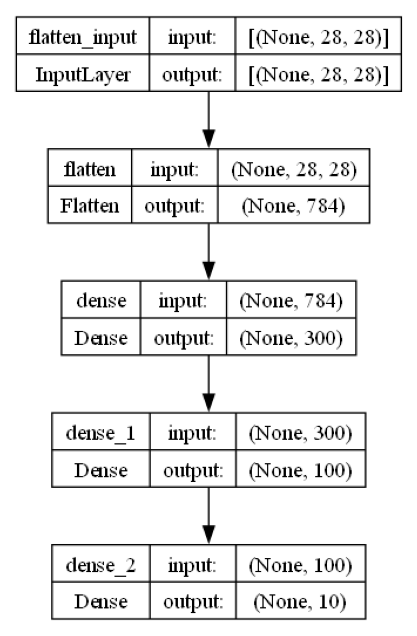

In [50]:
tf.keras.utils.plot_model(model, to_file='img/MLP-topology.png', show_shapes=True, show_layer_names=True)
plt.figure(figsize=(6, 8))
plt.imshow(mpimg.imread('img/MLP-topology.png'))
plt.axis('off')
plt.show()

We can show textual information about the layers using `model.layers`.

In [51]:
for i, layer in enumerate(model.layers):
    print(f"Layer number {i}, name '{layer.name}', and class {layer.__class__}")

Layer number 0, name 'flatten', and class <class 'keras.src.layers.reshaping.flatten.Flatten'>
Layer number 1, name 'dense', and class <class 'keras.src.layers.core.dense.Dense'>
Layer number 2, name 'dense_1', and class <class 'keras.src.layers.core.dense.Dense'>
Layer number 3, name 'dense_2', and class <class 'keras.src.layers.core.dense.Dense'>


Let's show the parameters (W and b) of the last layer.

In [52]:
weights, biases = model.layers[3].get_weights()
print("Shape of the weights of the last layer:", weights.shape)
print("Values of the weights of the first row in the last layer:", weights[0].round(decimals=3))
print("Biases of the last layer:", biases)

Shape of the weights of the last layer: (100, 10)
Values of the weights of the first row in the last layer: [-0.198  0.129  0.168 -0.233 -0.079  0.088  0.21   0.016 -0.158 -0.043]
Biases of the last layer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Weights are initialized randomly to help backprop know the influence of each neuron in the cost. Multiple initializers can be used in keras; all of them set random values. Depending on the activation function, some of them are more appropriate than others:
- Glorot/Xavier initializer for linear, tanh, sigmoid and softmax activation functions.s
- He initializer for ReLU, Leaky ReLU, ELU, GELU, Swish and Mish activation functions.
- LeCun for SELU activation function.

## Model compilation

We compile the model.
- Loss is sparse categorical cross entropy because the output is an int. If it was one-hot encoding, we would use categorical cross entropy.
- Adam optimizer, a stochastic gradient descent method that is based on adaptive momentum.
- We add accuracy as a metric (together with the loss values).

In [53]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

## Model training

We train the model for 6 epochs, with batch_size of 32 instances. *Important*: In this case we use a validation set. The validation data is used to evaluate the model's performance after each epoch, **with a dataset different to the one used for training**.

In [54]:
EPOCHS = 6
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/6
1563/1563 [==============================] - 8s 5ms/step - loss: 0.4938 - accuracy: 0.8231 - val_loss: 0.4284 - val_accuracy: 0.8398
Epoch 2/6
1563/1563 [==============================] - 7s 4ms/step - loss: 0.3669 - accuracy: 0.8660 - val_loss: 0.3744 - val_accuracy: 0.8640
Epoch 3/6
1563/1563 [==============================] - 7s 4ms/step - loss: 0.3261 - accuracy: 0.8798 - val_loss: 0.3561 - val_accuracy: 0.8754
Epoch 4/6
1563/1563 [==============================] - 7s 5ms/step - loss: 0.3033 - accuracy: 0.8881 - val_loss: 0.3574 - val_accuracy: 0.8735
Epoch 5/6
1563/1563 [==============================] - 7s 5ms/step - loss: 0.2881 - accuracy: 0.8925 - val_loss: 0.3376 - val_accuracy: 0.8762
Epoch 6/6
1563/1563 [==============================] - 7s 5ms/step - loss: 0.2693 - accuracy: 0.8977 - val_loss: 0.3368 - val_accuracy: 0.8818


Let's take a look at how test and train loss and accuracy evolved during training

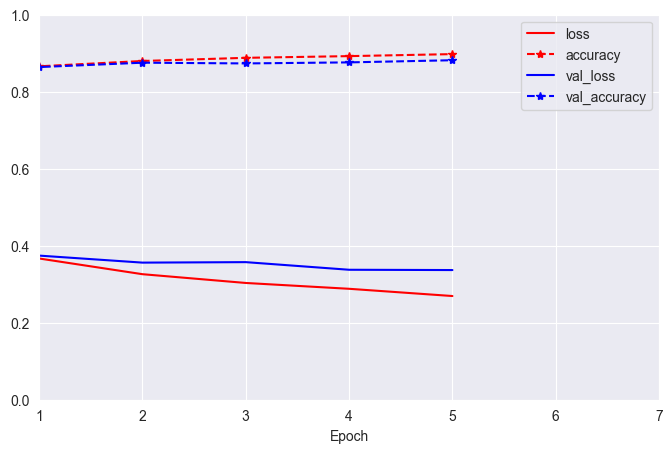

In [65]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[1, EPOCHS+1], ylim=[0, 1], grid=True, xlabel="Epoch",
    # red/blue, dashed(--), continuous (-), shape(. or *)
    style=["r-", "r--*", "b-", "b--*"])  # train-loss=red(-), train-accuracy=red(--*), val_loss=blue(-), val_accuracy=blue(--*)
plt.show()

You can see how:
- Train and validation losses decrease as the number of epochs increases.
- Train and validation accuracies increase as the number of epochs increases.
- Validation loss is usually higher than train loss (probably not in the first epochs because validation is computed after the whole epoch, while train is averaged after each mini-batch).
- Validation accuracy is usually lower than train loss (probably not in the first epochs).

## Model evaluation

Let's evaluate the model. For that purpose, we use the test set. *Never use the val or train sets!*

In [56]:
evaluation_results = model.evaluate(X_test, y_test)
print(f"Test loss: {evaluation_results[0]:.4f}. Test accuracy: {evaluation_results[1]:.4f}.")

313/313 [==============================] - 1s 3ms/step - loss: 0.3532 - accuracy: 0.8716
Test loss: 0.3532. Test accuracy: 0.8716.


## Making predictions (inference)

We use the model to predict the classes of the first 5 clothes. Remember we used softmax so, for each instance, we'll get 10 probabilities of belonging to each class.

In [57]:
SAMPLES_TO_PREDICT = 5
y_proba = model.predict(X_to_predict := X_test[:SAMPLES_TO_PREDICT])
print("Probabilities of belonging to each class:\n", y_proba.round(2))

1/1 [==============================] - 0s 58ms/step
Probabilities of belonging to each class:
 [[0.   0.   0.   0.   0.   0.01 0.   0.11 0.   0.88]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.22 0.   0.03 0.   0.   0.   0.74 0.   0.   0.  ]]


We get the class with the maximum probability.

In [58]:
y_pred = y_proba.argmax(axis=1)
print(f"Classes predicted for each instance (as number): {y_pred.tolist()}")
print(f"Classes predicted for each instance (as text): {[CLASS_LABELS[class_idx] for class_idx in y_pred]}")

Classes predicted for each instance (as number): [9, 2, 1, 1, 6]
Classes predicted for each instance (as text): ['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt']


Let's visualize how good we did. For each image, we show the predicted class as text.

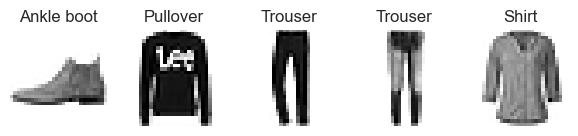

In [59]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_to_predict):
    plt.subplot(1, SAMPLES_TO_PREDICT, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(CLASS_LABELS[y_pred[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## Storing and restoring models

Training could take many CPU time, so it is a good idea to store models after training them. Then, the model could be loaded to be used for predictions (inference) or to continue training.

Model.`save` stores the model on disk. `tf.keras.models.load_model` loads a model from disk.

In [63]:
MODEL_FILE = "models/mlp_model.keras"
# create the directory in MODEL_FILE if it does not exist
os.makedirs(os.path.dirname(MODEL_FILE), exist_ok=True)
model.save(MODEL_FILE)
# We restore a serialized model from disk
new_model = tf.keras.models.load_model(MODEL_FILE)
print(f"Model loaded from '{MODEL_FILE}'.")
# And evaluate its performance
evaluation_results = new_model.evaluate(X_test, y_test)
print(f"Test loss: {evaluation_results[0]:.4f}. Test accuracy: {evaluation_results[1]:.4f}.")

Model loaded from 'models/mlp_model.keras'.
313/313 [==============================] - 1s 2ms/step - loss: 0.3532 - accuracy: 0.8716
Test loss: 0.3532. Test accuracy: 0.8716.


## ✨ Questions ✨ 

1. What do you think it will happen with a) train loss, b) val loss, c) train accuracy and d) val accuracy if you increase EPOCHS to 20. Write it down and then run it.
2. What has happened?
3. Why?
4. How do you think it could be solved? Name all the approaches you know.

### Answers

*Write your answers here*

